<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook (and the image needs to be where this notebook is expecting it)" width="500 px" align="left">

# _*Quantum Animations*_

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

***
### Contributors
James R. Wootton, IBM Research
***

In the notebook on [random terrain generation](random_terrain_generation.ipynb), we used qubits to make black and white pixel images.

Here we will use the same principle to make colour images. For this we use the fact that each colour can be expressed using the [RGB_color_model](https://en.wikipedia.org/wiki/RGB_color_model). This uses three values to expressed a colour, which tell us how much red, green and blue must be mixed together. These values are typically in the range from 0 to 255. For example, black is (0,0,0), white is (255,255,255) and red is (255,0,0). With this in mind, we can simply have three separate monochromatic process for these three colour channels, and then combine them at the end.

Another new aspect we'll introduce here is the ability to encode an existing image. For example, consider the 'image' below.

In [1]:
plumber = {(0, 0): (255, 255, 255), (0, 1): (255, 255, 255), (0, 2): (255, 255, 255), (0, 3): (255, 0, 0), (0, 4): (255, 0, 0), (0, 5): (255, 0, 0), (0, 6): (255, 255, 255), (0, 7): (92, 64, 51), (1, 0): (255, 255, 255), (1, 1): (255, 0, 0), (1, 2): (255, 255, 255), (1, 3): (0, 0, 255), (1, 4): (0, 0, 255), (1, 5): (0, 0, 255), (1, 6): (0, 0, 255), (1, 7): (92, 64, 51), (2, 0): (255, 0, 0), (2, 1): (255, 0, 0), (2, 2): (255, 192, 203), (2, 3): (255, 0, 0), (2, 4): (0, 0, 255), (2, 5): (0, 0, 255), (2, 6): (255, 255, 255), (2, 7): (255, 255, 255), (3, 0): (255, 0, 0), (3, 1): (255, 0, 0), (3, 2): (255, 192, 203), (3, 3): (255, 0, 0), (3, 4): (0, 0, 255), (3, 5): (0, 0, 255), (3, 6): (255, 255, 255), (3, 7): (255, 255, 255), (4, 0): (255, 255, 255), (4, 1): (255, 0, 0), (4, 2): (255, 255, 255), (4, 3): (0, 0, 255), (4, 4): (0, 0, 255), (4, 5): (0, 0, 255), (4, 6): (0, 0, 255), (4, 7): (92, 64, 51), (5, 0): (255, 255, 255), (5, 1): (255, 255, 255), (5, 2): (255, 255, 255), (5, 3): (255, 0, 0), (5, 4): (255, 0, 0), (5, 5): (255, 0, 0), (5, 6): (255, 255, 255), (5, 7): (92, 64, 51), (6, 0): (255, 255, 255), (6, 1): (255, 255, 255), (6, 2): (255, 255, 255), (6, 3): (255, 255, 255), (6, 4): (255, 255, 255), (6, 5): (210, 180, 140), (6, 6): (255, 255, 255), (6, 7): (255, 255, 255), (7, 0): (255, 255, 255), (7, 1): (255, 255, 255), (7, 2): (255, 255, 255), (7, 3): (107, 92, 72), (7, 4): (210, 180, 140), (7, 5): (107, 92, 72), (7, 6): (255, 255, 255), (7, 7): (255, 255, 255)}

This is an 8x8 pixel picture of a tanuki plumber, expressed as a Python dictionary. For each coordinate of a pixel, it gives the corresponding RGB values. This can then be turned into a proper image. In this notebook, we'll use the `PIL` package to do this.

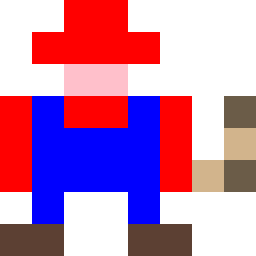

In [2]:
from PIL import Image
from IPython.display import display

def save_image(image,filename='image.png',scale=None):

    img = Image.new('RGB',(8,8))

    for x in range(img.size[0]):
        for y in range(img.size[1]):
            img.load()[x,y] = image[x,y]

    if scale:
        img = img.resize((256,256))

    img.save('game_engines/outputs/'+filename)

    
save_image(plumber,scale=[300,300],filename='image1.png')
display(Image.open('game_engines/outputs/image1.png'))

We will now turn this image into a quantum state. More precisely, we'll turn him into three states, with one for each colour channel. We will assign a bit string to each coordinate in the image, and use the probabilities of those bit strings as the value for the colour channels of that coordinate.

The above image has $8x8=2^6$ pixels, and so needs 6 qubits.

In [3]:
n = 6

When we set the probabilities for each bit string, we need to account for the fact that we do not have the freedom to do this arbitrarily. As probabilities, they must all be in the range from 0 to 1, and they must all sum to 1. We can do this simply by renormalizing. The corresponding amplitudes of the quantum state are then the square roots of these values.

First we must decide which bitstrings belong to which values. This can be done in exactly the same way as for the terrain generation notebook.

In [4]:
import numpy as np

L = int(2**(n/2))

grid = {}
for y in range(L):
    for x in range(L):
        grid[(x,y)] = ''

for (x,y) in grid:
    for j in range(n):
        if (j%2)==0:
            xx = np.floor(x/2**(j/2))
            grid[(x,y)] = str( int( ( xx + np.floor(xx/2) )%2 ) ) + grid[(x,y)]
        else:
            yy = np.floor(y/2**((j-1)/2))
            grid[(x,y)] = str( int( ( yy + np.floor(yy/2) )%2 ) ) + grid[(x,y)]

The following function then takes an image and a mapping of coordinates to bit strings and makes three quantum states, one for each colour channel. Each is expressed as a Python lists of amplitudes.

In [5]:
def image2state(image,grid):
    
    N = len(grid)
    state = [[0]*N,[0]*N,[0]*N] # different states for R, G and B

    for pos in image:
        for j in range(3):
            state[j][ int(grid[pos],2) ] = np.sqrt( image[pos][j] ) # amplitude is square root of colour value

    for j in range(3):        
        Z = sum(np.absolute(state[j])**2)
        state[j] = [amp / np.sqrt(Z) for amp in state[j]] # amplitudes are normalized
        
    return state


state = image2state(plumber,grid)

Now we can load the states into quantum circuits using the `initialize()` function of Qiskit, which initializes a circuit with a given quantum state. We can then manipulate the image in a quantum way. Here we'll use the statevector simulator to do this, which outputs the final quantum state.

In [6]:
from qiskit import *

backend = Aer.get_backend('statevector_simulator')

The final statevector is a set of amplitudes, but our encoding of RGB was done via the probabilities. For this reason, it would be useful to have the standard counts dictionary as we get from other simulators and real quantum devices. The following function performs the conversion.

In [7]:
def ket2counts (ket):
    
    counts = {}
    N = len(ket)
    n = int( np.log(N)/np.log(2) ) # figure out the qubit number that this state describes
    for j in range(N):
        string = bin(j)[2:]
        string = '0'*(n-len(string)) + string
        counts[string] = np.absolute(ket[j])**2 # square amplitudes to get probabilities
    
    return counts

Now let's have a simple example where we load the image in and then extract the results.

In [8]:
q = QuantumRegister(n)

counts = []
for j in range(3): # j=0 for red, j=1 for green, j=2 for blue
    qc = QuantumCircuit(q)
    qc.initialize( state[j], q )
    job = execute(qc, backend)
    counts.append( ket2counts( job.result().get_statevector() ) )

The only remaining job is to turn the three dictionaries of counts back into an image. This is going to be a bit ambiguous, because we need to undo our earlier normalization step. To do this, we'll assume that, for every colour channel, there is at least one pixel with the value 255. This means that the maximum probaility for each colour channel will be given the value 255, and all other values are assigned proportionally. This is done by the following function.

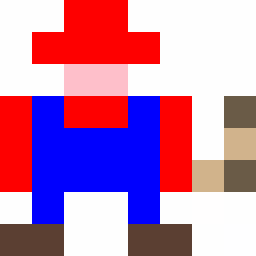

In [9]:
def counts2image(counts,grid):
    
    image = { pos:[0,0,0] for pos in grid}

    for j in range(3):

        rescale = 255/max(counts[j].values()) # rescale so that largest probability becomes value of 255

        for pos in image:
            try:
                image[pos][j] = int( rescale*counts[j][grid[pos]] )
            except:
                image[pos][j] = int( rescale*counts[j][grid[pos]] )

    for pos in image:
        image[pos] = tuple(image[pos])

    return image


save_image( counts2image(counts,grid), scale=[300,300], filename='image2.png' )
display(Image.open('game_engines/outputs/image2.png'))

Our brave adventurer has been inside a quantum circuit and emerged intact!

Now let's do some simple manipulation. We'll simply apply a rotation around the y axis over the course of a number of frames.

In [10]:
frame_num = 20

These will then be compiled into an animated PNG using the `apng` package. Note that you'll need to run this notebook yourself in order to see this.

In [11]:
from apng import APNG
import os

state = image2state(plumber,grid)

filenames = []
for f in range(frame_num):
        
    circuits = []
    for j in range(3):
        qc = QuantumCircuit(q)
        qc.initialize(state[j],q)
        qc.ry(2*np.pi*f/frame_num,q)
        circuits.append( qc )

    job = execute(circuits, backend)

    counts = []
    for j in range(3):
        counts.append( ket2counts( job.result().get_statevector(circuits[j]) ) )
        
    frame = counts2image(counts,grid)
    
    filename = 'frame_'+str(f)+'.png'
    save_image( counts2image(counts,grid), scale=[300,300], filename=filename)
    filenames.append( 'game_engines/outputs/' + filename )

APNG.from_files(filenames,delay=250).save('game_engines/outputs/animation.png')

for file in filenames:
    os.remove(file)

![](game_engines/outputs/animation.png)

In the above example, each qubit from each circuit is rotated in the y axis at the same rate. These rotations all cover the range from $0$ to $2\pi$ over the course of the frames. To explore different possibilities, we could choose different fractions of $2\pi$ to be covered over the frames. Setting this $>1$ will cause a faster rotation, and $<1$ will cause a slower one. Setting it to an integer will mean that the corresponding qubit will return to its original state by the final frame (or almost, anyway). For a non-integer, it will not.

Below you can choose values of these fractions for each qubit for each colour channel via Jupyter widgets.

In [12]:
import ipywidgets as widgets

def make_box():
    children = [widgets.FloatSlider(value=1,max=5.0,step=0.01,description='qubit '+str(qubit),show=True) for qubit in range(n)]
    box = widgets.VBox(children)
    return box

tab = widgets.Tab()
tab.children = [make_box() for j in range(3)]
channels = ['Red Channel','Green Channel','Blue Channel']
for j in range(3):
    tab.set_title(j, channels[j])
    
tab

Once you've chosen, run the cells below to extract the values and create the animation.

In [13]:
fraction = [[],[],[]]
for j in range(3):
    for qubit in range(n):
        fraction[j].append( tab.children[j].children[qubit].value)

In [14]:
state = image2state(plumber,grid)

filenames = []
for f in range(frame_num):
        
    circuits = []
    for j in range(3):
        qc = QuantumCircuit(q)
        qc.initialize(state[j],q)
        for qubit in range(n):
            qc.ry(2*np.pi*fraction[j][qubit]*f/frame_num,q[qubit])
        circuits.append( qc )

    job = execute(circuits, backend)

    counts = []
    for j in range(3):
        counts.append( ket2counts( job.result().get_statevector(circuits[j]) ) )
        
    frame = counts2image(counts,grid)
    
    filename = 'frame_'+str(f)+'.png'
    save_image( counts2image(counts,grid), scale=[300,300], filename=filename)
    filenames.append( 'game_engines/outputs/' + filename )

APNG.from_files(filenames,delay=250).save('game_engines/outputs/new_animation.png')

for file in filenames:
    os.remove(file)    

![](game_engines/outputs/new_animation.png)